In [302]:
%matplotlib inline
import pandas as pd
import random
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import graphviz
from sklearn.tree import DecisionTreeRegressor, export_graphviz

In [225]:
df = pd.read_csv('all.csv')

In [226]:
df.dropna(inplace=True)

In [199]:
df.benchmark.unique()

array(['stressng-stream', 'redisbench', 'stressng-cpu',
       'stressng-cpucache', 'stressng-mem'], dtype=object)

In [262]:
# 'raw' is STREAM's result in bytes per second
df.test.unique()

array(['raw', 'SET', 'GET', 'LPUSH', 'LPOP', 'af-alg', 'atomic', 'bsearch',
       'cpu', 'crypt', 'fp-error', 'hsearch', 'longjmp', 'lsearch',
       'matrix', 'opcode', 'qsort', 'tsc', 'tsearch', 'vecmath', 'rdrand',
       'cache', 'icache', 'context', 'full', 'malloc', 'memcpy', 'memfd',
       'oom-pipe', 'pipe', 'remap', 'rmap', 'stackmmap', 'str', 'stream',
       'tlb-shootdown', 'vm', 'zero', 'vm-rw'], dtype=object)

In [227]:
df.columns

Index([u'repetition', u'benchmark', u'machine', u'test', u'result'], dtype='object')

In [228]:
# pivot table to obtain features, where each microbenchmark is a feature
features = df.pivot_table(index=["machine","test"], values=['result'], fill_value=0, aggfunc=np.mean).unstack().reset_index()

In [229]:
features

machine         result                                \
test                                        GET           LPOP          LPUSH   
0          apt129.apt.emulab.net  374040.063333  391609.430000  388935.500000   
1          apt131.apt.emulab.net  379459.270000  395838.013333  392418.020000   
2          apt132.apt.emulab.net  375033.220000  394275.126667  392387.700000   
3          apt134.apt.emulab.net  371897.626667  388791.126667  390621.720000   
4             dwill.soe.ucsc.edu  447137.530000  466127.210000  470353.176667   
5                        issdm-0   83193.393333   76401.460000   75472.210000   
6                       issdm-20            NaN            NaN            NaN   
7                       issdm-31            NaN            NaN            NaN   
8                       issdm-34   94000.043333   85687.833333   84784.183333   
9                        issdm-6   97017.413333   89235.496667   88489.243333   
10       ms1103.utah.cloudlab.us  361775.626667  365831.450000  362978.676667   
11       ms1119.utah.cloudlab.us  446075.950000  465481.563333  463207.406667   
12       ms1128.utah.cloudlab.us  450392.363333  465659.030000  468819.280000   
13       ms1139.utah.cloudlab.us  455428.593333  471645.406667  480742.656667   
14    pc19.utahddc.geniracks.net  277179.023333  257401.853333  254068.290000   
15    pc22.utahddc.geniracks.net  259494.903333  304595.063333  294989.920000   
16    pc25.utahddc.geniracks.net  289122.026667  241097.973333  260170.693333   
17    pc31.utahddc.geniracks.net  268510.693333  256588.916667  252820.156667   
18              pc765.emulab.net  385946.906667  382484.190000  365852.853333   
19              pc767.emulab.net  339070.383333  385209.166667  364155.930000   
20              pc769.emulab.net  383919.406667  417551.146667  416558.040000   
21              pc773.emulab.net  357843.813333  391366.603333  383662.083333   
22                           pl2  294797.160000  319160.966667  319092.333333   
23                     rackform2  229422.153333  241140.546667  241663.440000   
24          scruffy.soe.ucsc.edu  287960.780000  300487.280000  308704.553333   

                                                                         \
test            SET        af-alg         atomic     bsearch      cache   
0     369012.196667  11429.093335  571432.287205  350.249847   3.733455   
1     357965.883333  11231.682711  571618.545614  350.715711   3.755695   
2     368723.633333  11292.795480  571848.404240  350.881769   3.889003   
3     367819.813333  11305.177065  572029.482044  350.859979   3.711258   
4     448402.053333  13174.108128  661370.219470  404.280597  11.644764   
5      77384.720000  19430.726661  532567.892367  173.709722  20.403301   
6               NaN  20221.352681  532607.725711  172.148171  20.158326   
7               NaN  23028.744008  532372.921129  171.497028  20.047181   
8      88092.793333   4373.819571  532277.202647  172.298595  20.270005   
9      91465.040000  23631.459453  532633.776161  171.565789  20.691726   
10    343346.096667   7386.557136  552274.263809  317.091545   6.889124   
11    443624.970000   7531.520971  552350.254823  316.940149   7.244718   
12    437654.783333   7433.999016  552979.840166  316.802497   6.733600   
13    455531.710000   7471.952947  552698.573720  317.277068   6.933598   
14    249527.763333   6773.822895  559359.810373  346.529095   4.489275   
15    230878.860000   6794.450802  561635.836707  348.685122   4.377914   
16    248087.550000   6791.481547  561371.971488  349.103847   4.511346   
17    255201.573333   6757.575804  561233.394897  348.866136   4.467134   
18    343544.623333   7447.339925  711090.737156  386.824710   3.555737   
19    327446.280000   7400.614163  709398.570599  386.968867   3.511295   
20    318065.540000   7523.479413  715381.253314  389.206176   3.600147   
21    339612.680000   7387.501425  712888.771680  387.171583   3.600190   
22    278593.573333   9630.868126  62

In [238]:
# flatten the index
cols = features.columns.get_level_values(1).values
cols[0] = 'machine'
features.columns = cols

In [251]:
# drop machines where redis benchmark didn't run OK
features = features.dropna(subset=['GET'])

In [257]:
# drop benchmarks that didn't run ok in ALL machines
colswithnan = features.columns[features.isnull().any()].tolist()
features = features.drop(colswithnan,axis=1)

In [258]:
features

,machine,GET,LPOP,LPUSH,SET,af-alg,atomic,bsearch,cache,context,...,remap,rmap,stackmmap,str,stream,tlb-shootdown,tsearch,vecmath,vm,zero
0,apt129.apt.emulab.net,374040.063333,391609.430000,388935.500000,369012.196667,11429.093335,571432.287205,350.249847,3.733455,4124.620693,...,267.014128,2426.719802,11.552395,28536.518069,10.374184,752.290742,15.128514,2430.970868,23144.030132,179476.288173
1,apt131.apt.emulab.net,379459.270000,395838.013333,392418.020000,357965.883333,11231.682711,571618.545614,350.715711,3.755695,4126.707973,...,267.560718,2322.471894,11.732597,28374.133232,10.289737,743.522529,15.171430,2421.878278,23144.208283,179102.659013
2,apt132.apt.emulab.net,375033.220000,394275.126667,392387.700000,368723.633333,11292.795480,571848.404240,350.881769,3.889003,4117.052777,...,267.907795,2212.846967,11.663679,28214.984306,10.387561,750.814762,15.165095,2431.284743,23144.547826,177563.162073
3,apt134.apt.emulab.net,371897.626667,388791.126667,390621.720000,367819.813333,11305.177065,572029.482044,350.859979,3.711258,4114.630640,...,267.976587,2731.660995,11.575497,28261.113370,10.379353,757.738728,15.072437,2432.747442,23144.304156,176558.454759
4,dwill.soe.ucsc.edu,447137.530000,466127.210000,470353.176667,448402.053333,13174.108128,661370.219470,404.280597,11.644764,4789.060847,...,321.586733,969.698612,0.133270,32861.728069,49.490774,946.177664,19.070878,2797.652275,71139.724369,208733.396994
5,issdm-0,83193.393333,76401.460000,75472.210000,77384.720000,19430.726661,532567.892367,173.709722,20.403301,1725.550942,...,186.653841,287.679967,0.088789,7556.726301,59.453477,198.088266,7.139233,765.458469,19723.190614,75332.215748
8,issdm-34,94000.043333,85687.833333,84784.183333,88092.793333,4373.819571,532277.202647,172.298595,20.270005,1881.853655,...,93.763099,221.438820,0.066549,7571.239690,56.985997,208.034377,6.867192,763.864156,19706.404249,71822.158275
9,issdm-6,97017.413333,89235.496667,88489.243333,91465.040000,23631.459453,532633.776161,171.565789,20.691726,3345.727874,...,359.623780,500.650142,0.066495,7566.350371,62.208589,210.981963,7.007778,764.900468,19698.486956,83172.557072
10,ms1103.utah.cloudlab.us,361775.626667,365831.450000,362978.676667,343346.096667,7386.557136,552274.263809,317.091545,6.889124,3462.291200,...,291.808698,2007.077182,1.844239,30041.032528,20.473834,433.206672,14.641134,2328.817236,71135.113420,249123.759887
11,ms1119.utah.cloudlab.us,446075.950000,465481.563333,463207.406667,443624.970000,7531.520971,552350.254823,316.940149,7.244718,3478.055181,...,292.226063,2184.149219,1.866493,30023.001896,20.532256,435.109909,14.710901,2325.538418,71135.689299,249316.005883


In [279]:
# obtain training set by selecting 85% of rows
train_set = features.sample(frac=.85)

# use the rest as the test set
test_set = features.ix[features.index.difference(train_set.index)]

In [284]:
# get features that we'll use
feature_columns = features.columns.difference(pd.Index(['machine','GET','LPOP','LPUSH','SET']))

In [280]:
# train regression
regr2 = DecisionTreeRegressor(max_depth=2)
regr5 = DecisionTreeRegressor(max_depth=5)

In [290]:
regr2.fit(train_set[feature_columns], train_set['SET'])
regr5.fit(train_set[feature_columns], train_set['SET'])

DecisionTreeRegressor(criterion='mse', max_depth=5, max_features=None,
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

In [291]:
y2 = regr2.predict(test_set[feature_columns])
y5 = regr5.predict(test_set[feature_columns])

In [287]:
y2

array([ 404230.58666667,   84424.88      ,  404230.58666667])

In [292]:
y5

array([ 368723.63333333,  233550.97333333,  443624.97      ])

In [288]:
test_set['SET']

3     367819.813333
8      88092.793333
13    455531.710000
Name: SET, dtype: float64

In [309]:
def get_dot_graph(tree, feature_names):
    export_graphviz(tree, feature_names=feature_columns, out_file="mytree.dot")
    with open("mytree.dot") as f:
        return f.read()    

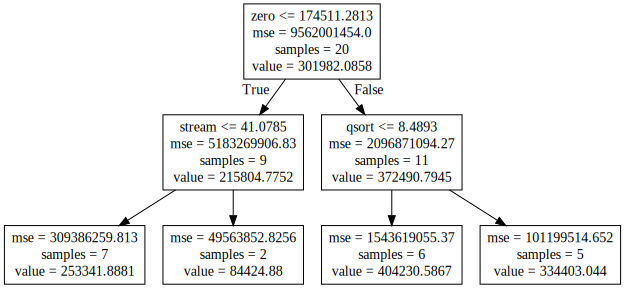

In [310]:
graphviz.Source(get_dot_graph(regr2, feature_columns))